In [1]:
import sys
import os
import subprocess
import pandas as pd
import numpy as np
import tempfile
import yaml

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

import os

from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl
nCPU= 20
N=4


2025-11-26


In [7]:
# 准备结果目录和流程所需config文件
# level 1
workdir = '/mnt/disk7t/xwj/axolotl_rev/'
title = 'pmuscle_36'
if title == 'gtex_nmd': # GTEx nmd
    pass
    
elif title == 'pmuscle_36':
    output_path = f'{workdir}/result/dataset_pmuscle_36'
    datasetdir = f'{workdir}/pmuscle_36_processed' 
    use = 'pmuscle36' # 13k gene min 10 reads
    # use = 'pmuscle36_0'
    tissues = pd.read_csv(f'{datasetdir}/tissues_{use}.tsv', sep='\t', index_col=0)
    phase =''
    outlier_sample_col = 'Sample'
    outlier_gene_col = 'Gene' 
else:
    pass
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'
print(samples_path)
tissues.head()

/mnt/disk7t/xwj/axolotl_rev//result/dataset_pmuscle_36/samples


,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,M,muscle,36,13573,/mnt/disk7t/xwj/axolotl_rev/pmuscle_36_process...,/mnt/disk7t/xwj/axolotl_rev/pmuscle_36_process...


In [22]:
## topn recall

def pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    """
    # 按predict和score排序
    ascend = score_order[ score_col ]
    sorted_data = res_data.pivot_table(columns=sample_col, index=gene_col, values=score_col).rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    new_df_outlier = df_outlier.copy() # must make a copy
    new_df_outlier['rank'] = outlier_rank
    return new_df_outlier, sorted_data

def sort_score_outlier_rank(res_data, df_outlier, ascend=True):
    sorted_data = res_data.rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    new_df_outlier = df_outlier.copy() # must make a copy
    new_df_outlier['rank'] = outlier_rank
    return new_df_outlier, sorted_data

In [5]:
# methods = [ 'OUTRIDER', 'OUTSINGLE', 'MyMethod']
baselines = [ 'OUTRIDER', 'OUTSINGLE', 'ABEILLE' ]
abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'pValue', 'zScore','padjust']
outrider_scores = [ 'padjust']
baselines = [ f'{m}_{score}' for m in ['OUTRIDER', 'ABEILLE'] for score in (outrider_scores if m=='OUTRIDER' else abl_scores) ] + ['OUTSINGLE']

mymethods = [ f'f{i}{md}' for i in list(range(20,24)) for md in ['L','I','O']] 
mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] 
             for m in ['L10', 'L20','L30', 'L40'] ]
# mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] for m in [ 'L30', ] ]
mymethods = [ f'{f}{m}' for f in ['f0.1', ] 
             for m in ['L20',] ]
methods = baselines + mymethods
# methods = ['OUTSINGLE', ] + mymethods

num = 49
print(num, phase, methods)

49  ['OUTRIDER_padjust', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTSINGLE', 'f0.1L20']


In [23]:
methods = ['OUTRIDER_padjust',
 'ABEILLE_anomaly_score',
 'ABEILLE_delta_count',
 'ABEILLE_divergence_score',
 'OUTSINGLE',
 'f0.1L20',
]

from tqdm import tqdm
# 为兼容以后的子集抽样，需要定义保存不同抽样方案的outlier
dict_outlier_setting = dict()
dict_outlier_setting['all'] = {} 

# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}


## 分析一个完整dataset，不带子集抽样
for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    dict_res = dict()
    dict_auprc = dict()
    dict_curve = dict()
    
    for k in dict_outlier_setting.keys():
        # --> level 2. (tissue, task) one tissue have many tasks
        if k == 'all':
            prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        else:
            pass # todo, add some change to prefix
        
        # 读入任务
        task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
        samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
        # all outlier
        # outliers_used = pd.read_csv(f'{samples_path}/{prefix}_outliers.txt', sep='\t',index_col=0)
        # valid split
        outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
        print(prefix, samples.shape, outliers_used.shape)

        if 'Sample' in outliers_used.columns:
            df_outlier = outliers_used
        else:
            outlier_sample_col = 'SAMPLE_ID'
            outlier_gene_col = 'Gene'
            df_outlier = outliers_used.rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})
        
        for m in methods:
            # ==> level 3. (tissue, task, method)
            dict_res = dict()
            dict_auprc = dict()
            dict_curve = dict()
            
            for j,row in task_config.iterrows():
                # ==> level 4. (tissue, task, method)
                if m.startswith('ABEILLE'):
                    method, score_col = m.split('_',1)
                    print(method, score_col)
                    res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                    res_data.index = [(s,g) for s,g in zip(res_data['Sample'], res_data['Transcript'])]
                    class_col = 'predict'
                    gene_col = 'Transcript'
                    sample_col = 'Sample'
                    _outlier, dict_curve[j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                                                   
                elif m.startswith('OUTRIDER'):
                    method, score_col = m.split('_',1)
                    print(method, score_col)
                    res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                    res_data.index = [(s,g) for s,g in zip(res_data['sampleID'], res_data['geneID'])]
                    class_col = 'aberrant'
                    gene_col = 'geneID'
                    sample_col = 'sampleID'
                    _outlier, dict_curve[j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)

                elif m == 'OUTSINGLE':
                    print(m)
                    df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                    _outlier, dict_curve[j] = sort_score_outlier_rank(df_pred, df_outlier)

                else: # my method
                    print(m)
                    df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                    _outlier, dict_curve[j] = sort_score_outlier_rank(df_pred, df_outlier)

    
            # m is done,
            file = f'{metric_output_path}/{prefix}_{m}_rank{phase}.pkl' # one tissue One method   
            outputdata = [ t, tn, i, dict_curve ]
            
            import pickle
            with open(file, 'wb') as f: 
                pickle.dump( outputdata,  f )


t00_M_s36_g13573 (1, 36) (22, 3)
OUTRIDER padjust
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTSINGLE
f0.1L20


In [ ]:
draw_methods = methods
plt.style.use('default')
# fig, axes = plt.subplots(len(tissues)+1, 1, figsize=(5, 5))

for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    k = 'all'
    dict_curve[k],dict_auprc[k] = dict(),dict()
    if k == 'all':
        prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    for m in draw_methods:
        
        file = f'{metric_output_path}/{prefix}_{m}_rank{phase}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
            print(tn, m)
        _t, _tn, _i, dict_curve[k][m] = data_load[0], data_load[1], data_load[2], data_load[3]
        
    dict_res_rank = dict.fromkeys(methods)
    for m in methods:
        dict_res_rank[m] = dict_curve[k][m][0]
        
    dict_res_rank['f0.1L20'] 

muscle OUTRIDER_padjust
muscle ABEILLE_anomaly_score
muscle ABEILLE_delta_count
muscle ABEILLE_divergence_score
muscle OUTSINGLE
muscle f0.1L20


<Axes: ylabel='Gene-Sample'>

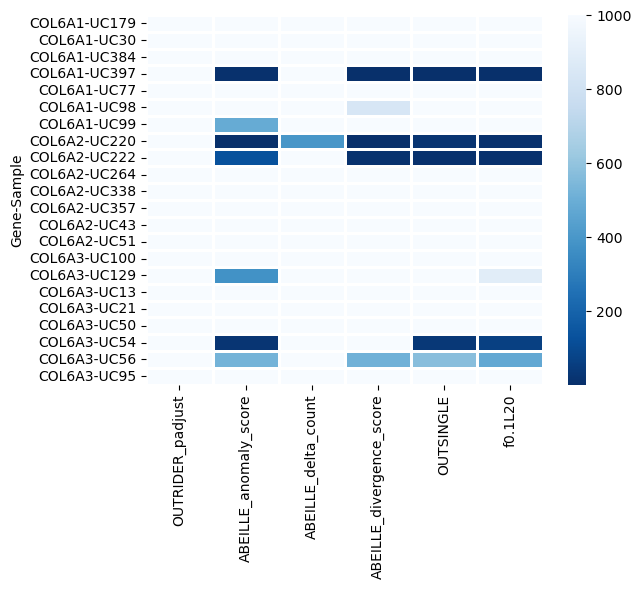

In [143]:
df_outlier
# pd.concat( [ dict_res_rank[k].loc[list_gene_symbols,list_less_sample] for k in methods ],
#                  axis=0, keys=methods, names=['method'])

df_outlier_rank = df_outlier.copy()
for m in methods:
    df_outlier_rank[m] = [ dict_res_rank[m].loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
draw = df_outlier_rank.set_index(keys=['Gene','Sample',]).drop(columns='ensg')
draw = draw.clip(upper=1000)
# draw = draw.transform(lambda x: np.log2(x+1))

sns.heatmap( draw, cmap=mycolor,linewidths=1)


In [140]:
list_less_sample = [
    'UC397',
    'UC98',
    'UC220',
    'UC222',
    'UC51', 
    'UC56',
    'UC384',
    # 'M13-16',
    # 'M13-25',
    # 'M13-33',
    # 'M13-35',
    ]
# list_gene_symbols = ['COL6A1','COL6A2','COL6A3','COL6A6',
list_gene_symbols =  ['CAPN3','DYSF','TTN','TCAP','LMNA']

draw = pd.concat( [ dict_res_rank[k].loc[list_gene_symbols,list_less_sample] for k in methods ],
                 axis=0, keys=methods, names=['method'])
draw.columns.name ='sample'
draw.index.names =['method','gene']
draw = draw.stack().rename('rank').reset_index()
# draw = draw.transform(lambda x: np.log2(x+1))
# draw.sort_values(by='rank')
draw.groupby('method')['rank'].mean()

method
ABEILLE_anomaly_score       8767.800000
ABEILLE_delta_count         6643.114286
ABEILLE_divergence_score    8050.085714
OUTRIDER_padjust            6884.857143
OUTSINGLE                   7522.628571
f0.1L20                     7292.114286
Name: rank, dtype: float64

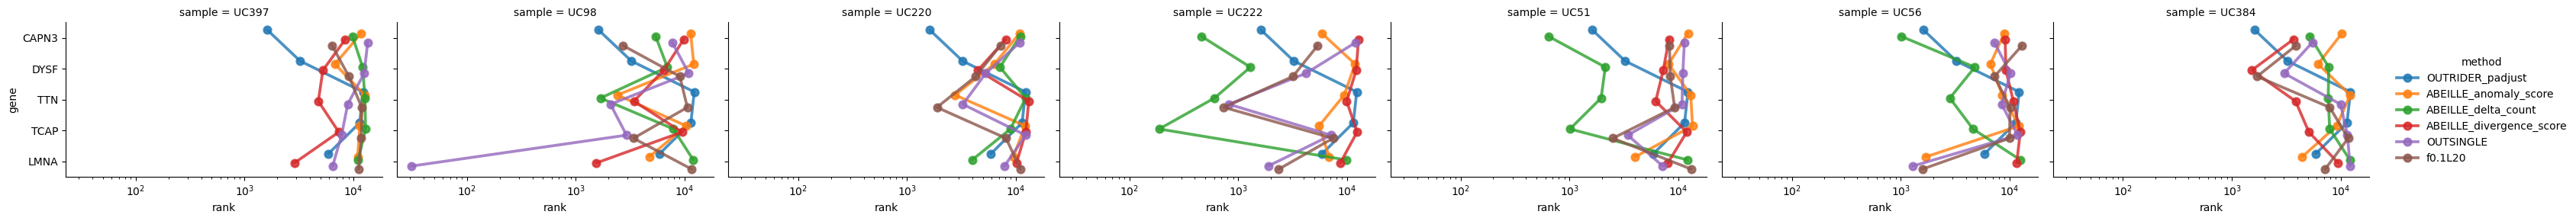

In [141]:
sns.catplot(data=draw, y='gene', x='rank', kind='point', dodge=0.5, alpha=0.8, hue='method', 
            col='sample',
            palette='tab10',log_scale=True, orient='h', height=3, aspect=1.5 )

KeyError: 'OUTRIDER_padjust'

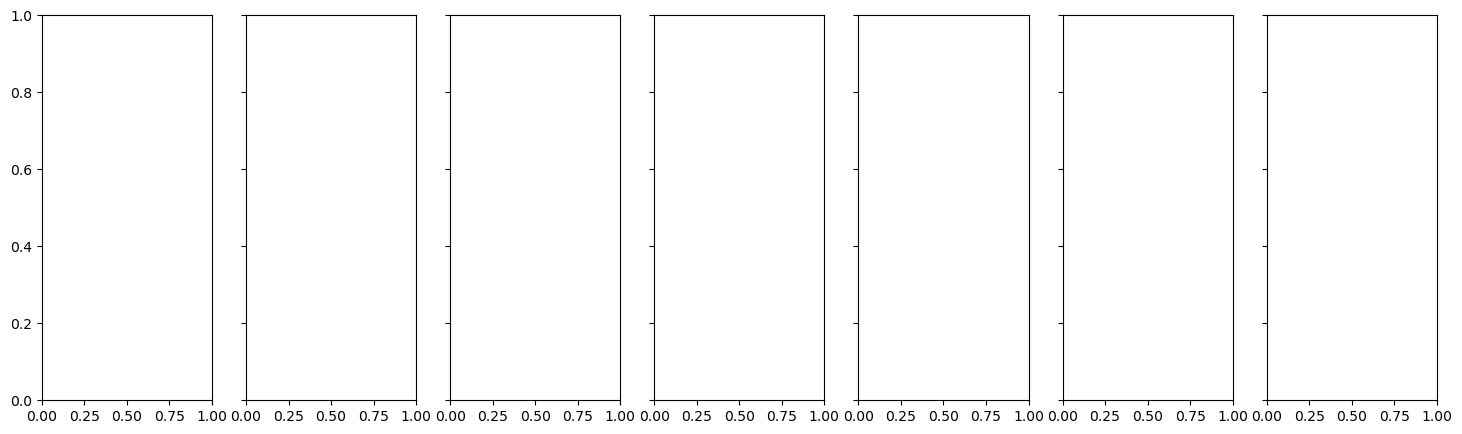

In [142]:

# 'UC220', 'UC222', 'UC397', 'UC51', 'UC98']
## 2023-12-6 heatmap去掉一些行
f, axes = plt.subplots(nrows=1, ncols=len(methods)+1, sharey='row', figsize=(18,5))

mycolor = 'Blues_r'
highlight = 'r'
for i in range(len(methods)):

    m = list(methods)[i]    
    g = sns.heatmap(draw.loc[m].T, robust=False, square=True, linewidths=0.8,linecolor='w',
                    cmap=mycolor,vmin=0, vmax=10, rasterized=True,cbar=False,ax=axes[i],)
#     axes[i].set_ylabel(m)
    axes[i].set_title(m)
    # axes[i].add_patch(plt.Rectangle((0, 0), 1, 2, ls='--', lw=0.5, ec=highlight, fc="none"))
    # axes[i].add_patch(plt.Rectangle((1, 2), 1, 2, ls='--', lw=0.5, ec=highlight, fc="none"))
    # axes[i].add_patch(plt.Rectangle((2, 4), 1, 1, ls='--', lw=0.5, ec=highlight, fc="none"))
    # axes[i].add_patch(plt.Rectangle((3, 0), 5.95, 10.95, ls='--', lw=0.5, ec='black', fc="none"))
i = i + 1
# f.delaxes(axes[i])
# cb = g.figure.colorbar(g.collections[0],ax=axes[i], location='left')
# myticks = [0,1,2,3,4,5,6,7,8,9]
# cb.set_ticks(myticks)
# cb.set_ticklabels([ x for x in range(1,2000) if np.log2(x) in myticks ])
# cb.set_label('Rank of anormaly score')
plt.tight_layout()